# Cargar MNIST y generar una versión corrompida por ruido


Using TensorFlow backend.


11493376/11490434 [==============================] - 1s 0us/step
Original images
Noisy images


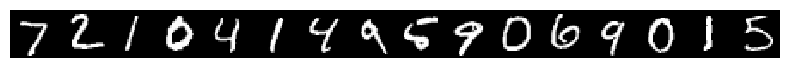

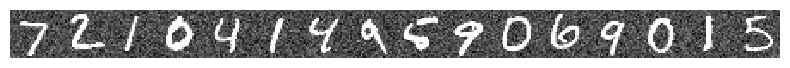

In [ ]:
from keras.datasets import mnist
import keras.backend as K
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(1337)

def load_data(noise_location,noise_strength):
  (x_train, _), (x_test, _) = mnist.load_data()

  image_size = x_train.shape[1]
  x_train = np.reshape(x_train, [-1, 28,28, 1])/255.0
  x_test = np.reshape(x_test, [-1, 28,28, 1])/255.0
  input_shape = (28,28, 1)

  # Generate corrupted MNIST images by adding noise with normal dist
  # centered at 0.5 and std= noise_strength
  noise = np.random.normal(loc=noise_location, scale=noise_strength, size=x_train.shape)
  x_train_noisy = x_train + noise
  noise = np.random.normal(loc=noise_location, scale=noise_strength, size=x_test.shape)
  x_test_noisy = x_test + noise

  x_train_noisy = np.clip(x_train_noisy, 0., 1.) # restrict to range 0-1
  x_test_noisy = np.clip(x_test_noisy, 0., 1.) # restrict to range 0-1
  return x_train,x_train_noisy,x_test,x_test_noisy,input_shape

def show_as_single_image(imgs):
  n,h,w,c=imgs.shape
  imgs = imgs.reshape((n, h,w))
  imgs = imgs.swapaxes(1,2).reshape((n*w, h)).swapaxes(0,1)
  imgs = (imgs * 255).astype(np.uint8)

  plt.figure(figsize=(1*8,n*8),dpi=100)
  plt.axis('off')
  plt.imshow(imgs, interpolation='none', cmap='gray')
  plt.tight_layout()


# You can play around with these parameters to generate more or less noisy samples
noise_location=0.3
noise_strength=0.1
x_train,x_train_noisy,x_test,x_test_noisy,input_shape = load_data(noise_location,noise_strength)

num=16
print("Original images")
show_as_single_image(x_test[:num])
print("Noisy images")
show_as_single_image(x_test_noisy[:num])

# Entrenar un autoencoder para generar una versión restaurada a partir de una versión ruidosa de la imagen


In [ ]:
import keras
from keras.layers import Activation, Dense, Input
from keras.layers import Conv2D, Flatten
from keras.layers import Reshape, Conv2DTranspose
from keras.layers import MaxPooling2D,UpSampling2D

from keras.models import Model
import keras.backend as K
from PIL import Image




def ConvolutionalAutoencoder(input_shape,filters):
  def generate_encoder():
    encoder_input = Input(shape=input_shape, name='encoder_input')

    x = Conv2D(filters, (3, 3), activation='relu', padding='same')(encoder_input)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(filters//2, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(filters//2, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    encoded_shape = K.int_shape(x)[1:]

    encoder = Model(encoder_input, x, name='encoder')
    return encoder,encoder_input,encoded_shape

  def generate_decoder(encoded_shape):
    latent_input = Input(shape=encoded_shape, name='decoder_input')

    x = Conv2D(filters//2, (3, 3), activation='relu', padding='same')(latent_input)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(filters//2, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(filters, (3, 3), activation='relu')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    decoder = Model(latent_input, x, name='decoder')
    return decoder,latent_input

  encoder,encoder_input,encoded_shape = generate_encoder()
  decoder,latent_input = generate_decoder(encoded_shape)
  autoencoder = Model(encoder_input, decoder(encoder(encoder_input)), name='autoencoder')
  return autoencoder,encoder,decoder,encoded_shape


filters=32
autoencoder,encoder,decoder,encoded_shape=ConvolutionalAutoencoder(input_shape,filters)
autoencoder.compile(loss='binary_crossentropy', optimizer='adam')

print(autoencoder.summary())
print(encoder.summary())
print(decoder.summary())

batch_size = 128
# Train the autoencoder
autoencoder.fit(x_train_noisy,
                x_train,
                validation_data=(x_test_noisy,x_test),
                epochs=30,
                batch_size=batch_size)















Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 28, 28, 1)         0         
_________________________________________________________________
encoder (Model)              (None, 4, 4, 16)          7264      
_________________________________________________________________
decoder (Model)              (None, 28, 28, 1)         9569      
Total params: 16,833
Trainable params: 16,833
Non-trainable params: 0
_________________________________________________________________
None
Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 28, 28, 1)         0         
____________________________________________________________

# Mostrar imágenes originales, ruidosas, y restauradas


Original images
Noisy images
Restored images


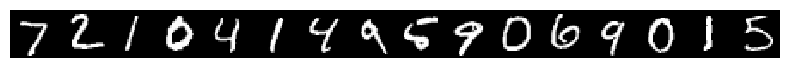

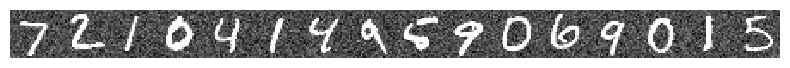

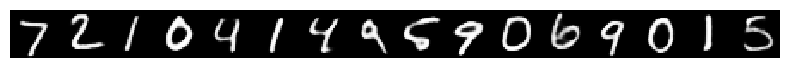

In [ ]:

# Predict the Autoencoder output from test images
x_decoded = autoencoder.predict(x_test_noisy)

num=16
print("Original images")
show_as_single_image(x_test[:num])
print("Noisy images")
show_as_single_image(x_test_noisy[:num])
print("Restored images")
show_as_single_image(x_decoded[:num])